In [1]:
import numpy as np
import pandas as pd

In [2]:
# データの取り込み
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

### 1, 各変数の特徴をプロット図から探る

探索的データ解析(EDA)はデータの構造を把握することを目的とする。\
データの特徴を探究し、構造を理解することを目的とする。\
データを視覚化したり、データのパターンを探したり、特徴量やターゲットの関係性/相関性を感じ取るのが目的

In [3]:
# グラフプロット用のライブラリをインポートする
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

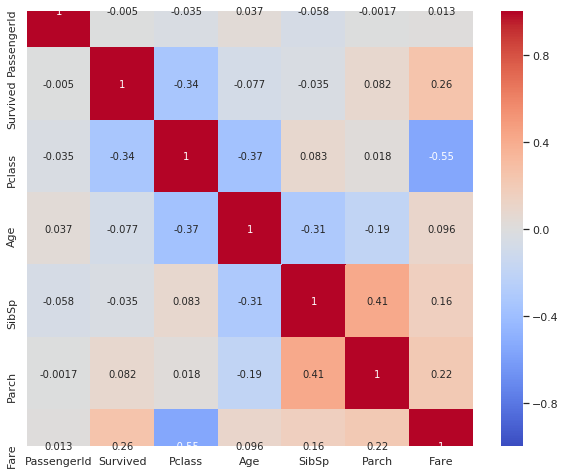

In [4]:
# 各パラメータの相関マトリックスを作成
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, fmt='.2g', vmin = -1,
            vmax = 1, center = 0, cmap = 'coolwarm')

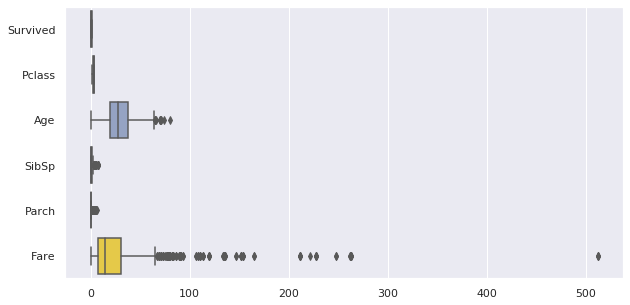

In [5]:
# 数値型の変数を選び出し、箱髭図を作成する
numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(data = train_df[numeric_cols], orient = 'h', palette = 'Set2')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f235462e390>,
      dtype=object)

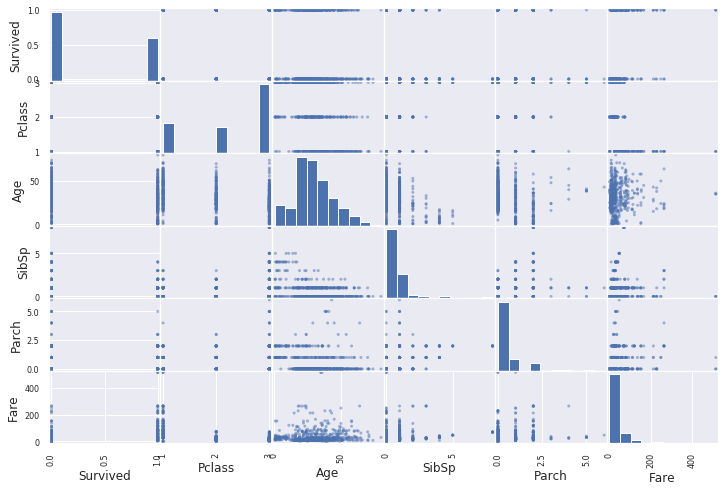

In [6]:
# 散布図の一覧を作成する
from pandas.plotting import scatter_matrix
scatter_matrix(train_df[numeric_cols], figsize= (12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f23537f5350>,
      dtype=object)

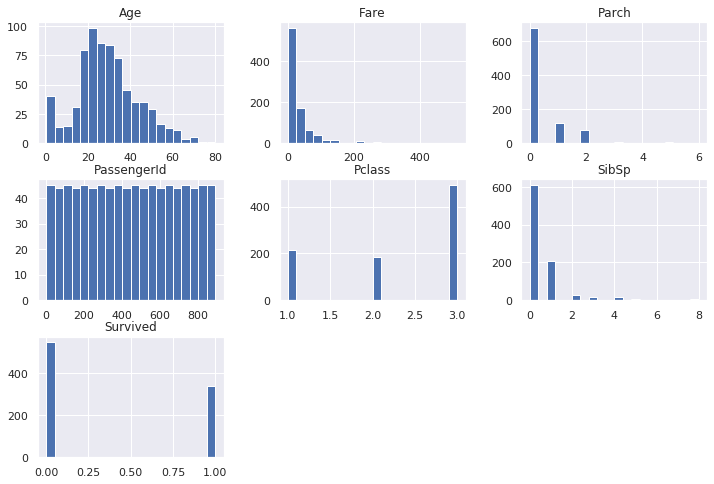

In [7]:
# 各変数のヒストグラムを作成する
train_df.hist(bins = 20, figsize = (12,8))

Text(0.5, 1.0, 'Count Survived for each Class')

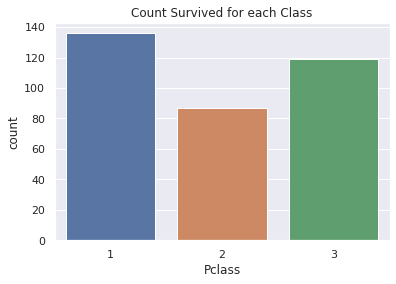

In [8]:
# Pclassごとのカウント数を集計する
sns.countplot(train_df[train_df['Survived'] == 1]['Pclass']).set_title('Count Survived for each Class')

In [9]:
# Pclassごとのカウント数を表示
len(train_df[train_df['Pclass'] == 1]), len(train_df[train_df['Pclass'] == 2]), len(train_df[train_df['Pclass'] == 3])

(216, 184, 491)

In [10]:
# Pclassごとに生存した人の数を表示
train_df[train_df['Pclass'] == 1]['Survived'].sum(), train_df[train_df['Pclass'] == 2]['Survived'].sum(), train_df[train_df['Pclass'] == 3]['Survived'].sum()   

(136, 87, 119)

In [11]:
percentages = []
first = train_df[train_df['Pclass'] == 1]['Survived'].sum() / len(train_df[train_df['Pclass'] == 1])
second = train_df[train_df['Pclass'] == 2]['Survived'].sum() / len(train_df[train_df['Pclass'] == 2])
third = train_df[train_df['Pclass'] == 3]['Survived'].sum() / len(train_df[train_df['Pclass'] == 3])
percentages.append(first)
percentages.append(second)
percentages.append(third)

In [12]:
percents = pd.DataFrame(percentages)
percents.index+=1

Text(0.5, 1.0, 'Percent Survived for Passenger Class')

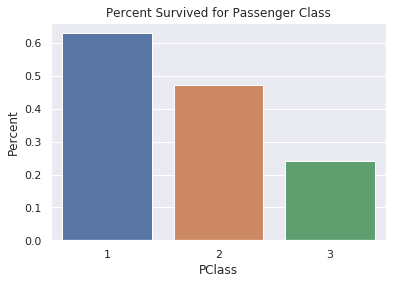

In [13]:
percents['PClass'] = ['1', '2', '3']
cols= ['Percent', 'PClass']
percents.columns = [i for i in cols]
sns.barplot(y = 'Percent', x = 'PClass', data = percents).set_title('Percent Survived for Passenger Class')

### 2, XGBoostingで分析を実施
GBDT(勾配ブースティング木)の一種であるxgboostを利用して予測を行う。\
xgboostはkaggleのテーブルデータ予測で一番使われる手法である。\
「初手xgboost」

In [22]:
from sklearn.preprocessing import LabelEncoder

# 使用可能な説明変数を全て使用する
y_train1 = train_df["Survived"].copy()
x_train1 = train_df[["Pclass", "Sex", "Age", "Fare", "SibSp", "Parch", "Embarked"]].copy()
x_test1 = test_df[["Pclass", "Sex", "Age", "Fare", "SibSp", "Parch", "Embarked"]].copy()

# それぞれのカテゴリ変数にlabel encodingを適用する
for c in ['Sex', 'Embarked']:
    # 学習データに基づいてどう変換するかを定める
    le = LabelEncoder()
    le.fit(x_train1[c].fillna('NA'))
    
    # 学習データ、テストデータを変換する
    x_train1[c] = le.transform(x_train1[c].fillna('NA'))
    x_test1[c] = le.transform(x_test1[c].fillna('NA'))

In [23]:
from xgboost import XGBClassifier

In [24]:
# モデルの作成および学習データを与えての学習
model = XGBClassifier(n_estimators=20, random_state=71)
model.fit(x_train1, y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=71, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
# テストデータの予測値を確率で出力する
pred = model.predict_proba(x_test1)[:, 1]

# テストデータの予測値を二値に変換する
pred_label = np.where(pred > 0.5, 1, 0)

# 提出用ファイルの作成
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': pred_label})
submission.to_csv('submit3.csv', index=False)

### 3. クロスバリデーション
ここまで、モデルの精度はkaggle提出時のスコアで判断していた。\
訓練データを分割し、最適なモデルを探すクロスバリデーションといった手法を紹介する。

In [26]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold

# 各foldのスコアを保存するリスト
scores_accuracy = []
scores_logloss = []

In [27]:
# クロスバリデーションを行う
# 学習データを4つに分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(x_train1):
    # 学習データを学習データとバリデーションデータに分ける
    x_tr, x_va = x_train1.iloc[tr_idx], x_train1.iloc[va_idx]
    y_tr, y_va = y_train1.iloc[tr_idx], y_train1.iloc[va_idx]
    
    # モデルの学習を行う
    model = XGBClassifier(n_estimators=20, random_state=71)
    model.fit(x_tr, y_tr)
    
    # バリデーションデータの予測値を確率で出力する
    va_pred = model.predict_proba(x_va)[:, 1]
    
    # バリデーションデータでのスコアを計算する
    logloss = log_loss(y_va, va_pred)
    accuracy = accuracy_score(y_va, va_pred > 0.5)
    
    # そのfoldのスコアを保存する
    scores_logloss.append(logloss)
    scores_accuracy.append(accuracy)

In [28]:
# 各foldのスコアの平均を出力する
logloss = np.mean(scores_logloss)
accuracy = np.mean(scores_accuracy)
print(f'logloss: {logloss:.4f}, accuracy: {accuracy:.4f}')

logloss: 0.4347, accuracy: 0.8171


### 4. モデルのチューニング
各モデルにはいくつかのモデルパラメータが存在する。\
各パラメータを動かして最適なパラメータを見つけてみよう。\
max_depth:分岐の最大深さ\
min_child_weight:葉の重みの加減

In [29]:
import itertools

# チューニング候補とするパラメータを準備する
param_space = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1.0, 2.0, 4.0]
}

# 探索するハイパーパラメータの組み合わせ
param_combinations = itertools.product(param_space['max_depth'], param_space['min_child_weight'])

# 各パラメータの組み合わせ、それに対するスコアを保存するリスト
params = []
scores = []

In [30]:
# 各パラメータの組み合わせごとに、クロスバリデーションで評価を行う
for max_depth, min_child_weight in param_combinations:
    
    score_folds = []
    # クロスバリデーションを行う
    # 学習データを４つに分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
    kf = KFold(n_splits=4, shuffle=True, random_state=71)
    for tr_idx, va_idx in kf.split(x_train1):
        # 学習データを学習データとバリデーションデータに分ける
        x_tr, x_va = x_train1.iloc[tr_idx], x_train1.iloc[va_idx]
        y_tr, y_va = y_train1.iloc[tr_idx], y_train1.iloc[va_idx]
    
        # モデルの学習を行う
        model = XGBClassifier(n_estimators=20, random_state=71,
                              max_depth=max_depth, min_child_weight=min_child_weight)
        model.fit(x_tr, y_tr)
    
        # バリデーションデータの予測値を確率で出力する
        va_pred = model.predict_proba(x_va)[:, 1]
    
        # バリデーションデータでのスコアを計算する
        logloss = log_loss(y_va, va_pred)
        score_folds.append(logloss)
        
    # 各foldのスコアを平均する
    score_mean = np.mean(score_folds)
    
    # 各パラメータの組み合わせ、それに対するスコアを保存する
    params.append((max_depth, min_child_weight))
    scores.append(score_mean)
    
# 最もスコアが良いものをベストなパラメータとする
best_idx = np.argsort(scores)[0]
best_param = params[best_idx]
print(f'max_depth: {best_param[0]}, min_child_weight: {best_param[1]}')

max_depth: 3, min_child_weight: 2.0


### 5. アンサンブル学習

#### 5-1. XGBoosting学習

In [32]:
# パラメータ調整の結果を使用し、XGBoostingを再度実施
# モデルの作成および学習データを与えての学習
model_xgb = XGBClassifier(n_estimators=20, random_state=71,
                      max_depth=3, min_child_weight=2.0)
model_xgb.fit(x_train1, y_train1)
pred_xgb = model_xgb.predict_proba(x_test1)[:, 1]

#### 5-2. ロジスティック回帰モデル

In [33]:
# 事前準備
train_df2 = pd.read_csv('../data/train.csv')
test_df2 = pd.read_csv('../data/test.csv')

# 訓練データの加工
train_df2["Age"] = train_df2["Age"].fillna(train_df2["Age"].median())
train_df2["Embarked"] = train_df2["Embarked"].fillna("S")

train_df2["Sex"][train_df2["Sex"] == "male"] = 0
train_df2["Sex"][train_df2["Sex"] == "female"] = 1
train_df2["Embarked"][train_df2["Embarked"] == "S"] = 0
train_df2["Embarked"][train_df2["Embarked"] == "C"] = 1
train_df2["Embarked"][train_df2["Embarked"] == "Q"] = 2

# テストデータの加工
test_df2["Age"] = test_df2["Age"].fillna(test_df2["Age"].median())
test_df2.Fare[152] = test_df2.Fare.median()

test_df2["Sex"][test_df2["Sex"] == "male"] = 0
test_df2["Sex"][test_df2["Sex"] == "female"] = 1
test_df2["Embarked"][test_df2["Embarked"] == "S"] = 0
test_df2["Embarked"][test_df2["Embarked"] == "C"] = 1
test_df2["Embarked"][test_df2["Embarked"] == "Q"] = 2

# データ型の加工
train_df2["Sex"] = train_df2["Sex"].astype(int)
train_df2["Embarked"] = train_df2["Embarked"].astype(int)
test_df2["Sex"] = test_df2["Sex"].astype(int)
test_df2["Embarked"] = test_df2["Embarked"].astype(int)

# 使用可能な説明変数を全て使用する
y_train2 = train_df2["Survived"].copy()
x_train2 = train_df2[["Pclass", "Sex", "Age", "Fare", "SibSp", "Parch", "Embarked"]].copy()

x_test2 = test_df2[["Pclass", "Sex", "Age", "Fare", "SibSp", "Parch", "Embarked"]].copy()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added bac

In [34]:
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデル
model_lr = LogisticRegression(solver='lbfgs', max_iter=300)
model_lr.fit(x_train2, y_train2)

pred_lr = model_lr.predict_proba(x_test2)[:, 1]

#### 5-3 アンサンブルの実施

それぞれの予測結果を掛け合わせることをアンサンブル学習という。

In [35]:
# 予測値の加重平均をとる
pred = pred_xgb * 0.8 + pred_lr * 0.2
pred_label = np.where(pred > 0.5, 1, 0)

In [36]:
# 提出用ファイルの作成
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': pred_label})
submission.to_csv('submit4.csv', index=False)